In [1]:
import meshplot as mp 
import igl 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
import os
import shapely
from shapely.geometry import Point
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import Polygon
import sympy
#from sympy import Point,Line#,Polygon


**Defining the 3d cylindrical mesh**

N = Number of unit meshes along a radii
r = splitting N radiis of OD - ID (43-18)
thetasteps = number of lines split among 360 degree 
z_steps= number of depth elements in z 
z= Depth elements devided for 60mm 
nodes= contains all cordinates required for the mesh 
e_list= contains 8 tuple nodes defining a rectangular mesh 

In [2]:
N= 17
IR=15
OR=50
r= np.linspace(IR, OR, N)
thetasteps= 72
dt=2*np.pi/thetasteps
theta=  np.linspace(0, 2*np.pi-dt, thetasteps)

z_steps= 21
z=np.linspace(0,60,z_steps)

z_count=1
count=1

nodes=[]


for i in range(z_steps):
    for j in range(N):
        for k in range(thetasteps):
            nodes.append([count,
                                r[j]*np.cos(theta[k]),
                                r[j]*np.sin(theta[k]),
                                z[i]])
            count=count+1
               

e_list=[]
            

for m in range(0,z_steps-1):
    lis=np.arange(1+m*thetasteps*N,(m+1)*thetasteps*N-thetasteps+1,1)
    #print(len(lis),lis)
    for g in range(len(lis)):
        if lis[g]%thetasteps==0:
            #print(lis[g])
            n= int(lis[g]/thetasteps)
            e_list.append([z_count, 
                                lis[g], 
                                (lis[g]+1)%thetasteps +(n-1)*thetasteps, 
                                (lis[g]+thetasteps+1)%thetasteps+n*thetasteps, 
                                lis[g]+thetasteps,
                                lis[g]+ (N*thetasteps), 
                                (lis[g]+1)%thetasteps +(n-1)*thetasteps+ (N*thetasteps),
                                (lis[g]+thetasteps+1)%thetasteps+n*thetasteps+ (N*thetasteps), 
                                lis[g]+thetasteps + (N*thetasteps)])

        else:
            e_list.append([z_count, 
                                lis[g], 
                                (lis[g]+1), 
                                (lis[g]+thetasteps+1), 
                                lis[g]+thetasteps,
                                lis[g]+ (N*thetasteps), 
                                (lis[g]+1)+ (N*thetasteps),
                                (lis[g]+thetasteps+1)+ (N*thetasteps), 
                                lis[g]+thetasteps + (N*thetasteps)])
        z_count=z_count+1

#print(r)
        
#print(e_list) 




In [3]:
#visualizing all point on a 2d cross-section 

#X=[item[1] for item in nodes]
#Y=[item[2] for item in nodes] 
#Z=[item[3] for item in nodes]
#plt.scatter(X,Y,s=3,color="red")


#selecting nodes and coordinates on the front facing 2d cross-section and appending them to a list "ele"
ele=np.zeros(shape=(len(e_list),5,2))

for i in range(len(e_list)):
    ele[i]=[[nodes[e_list[i][1]-1][1],nodes[e_list[i][1]-1][2]],
              [nodes[e_list[i][2]-1][1],nodes[e_list[i][2]-1][2]],
              [nodes[e_list[i][3]-1][1],nodes[e_list[i][3]-1][2]],
              [nodes[e_list[i][4]-1][1],nodes[e_list[i][4]-1][2]],
              [nodes[e_list[i][1]-1][1],nodes[e_list[i][1]-1][2]]]
    #xs, ys = zip(*ele[i])
    #plt.plot(xs,ys,color='blue') 

    
plt.rcParams['figure.figsize'] = [40, 40]

#visualizing the 2d cross section with elements 
plt.show()



**Metal area defined**
Deafult configuration where the outermost radiie consist of metal 

- relevant metal node numbers are appended to a list 'metal'

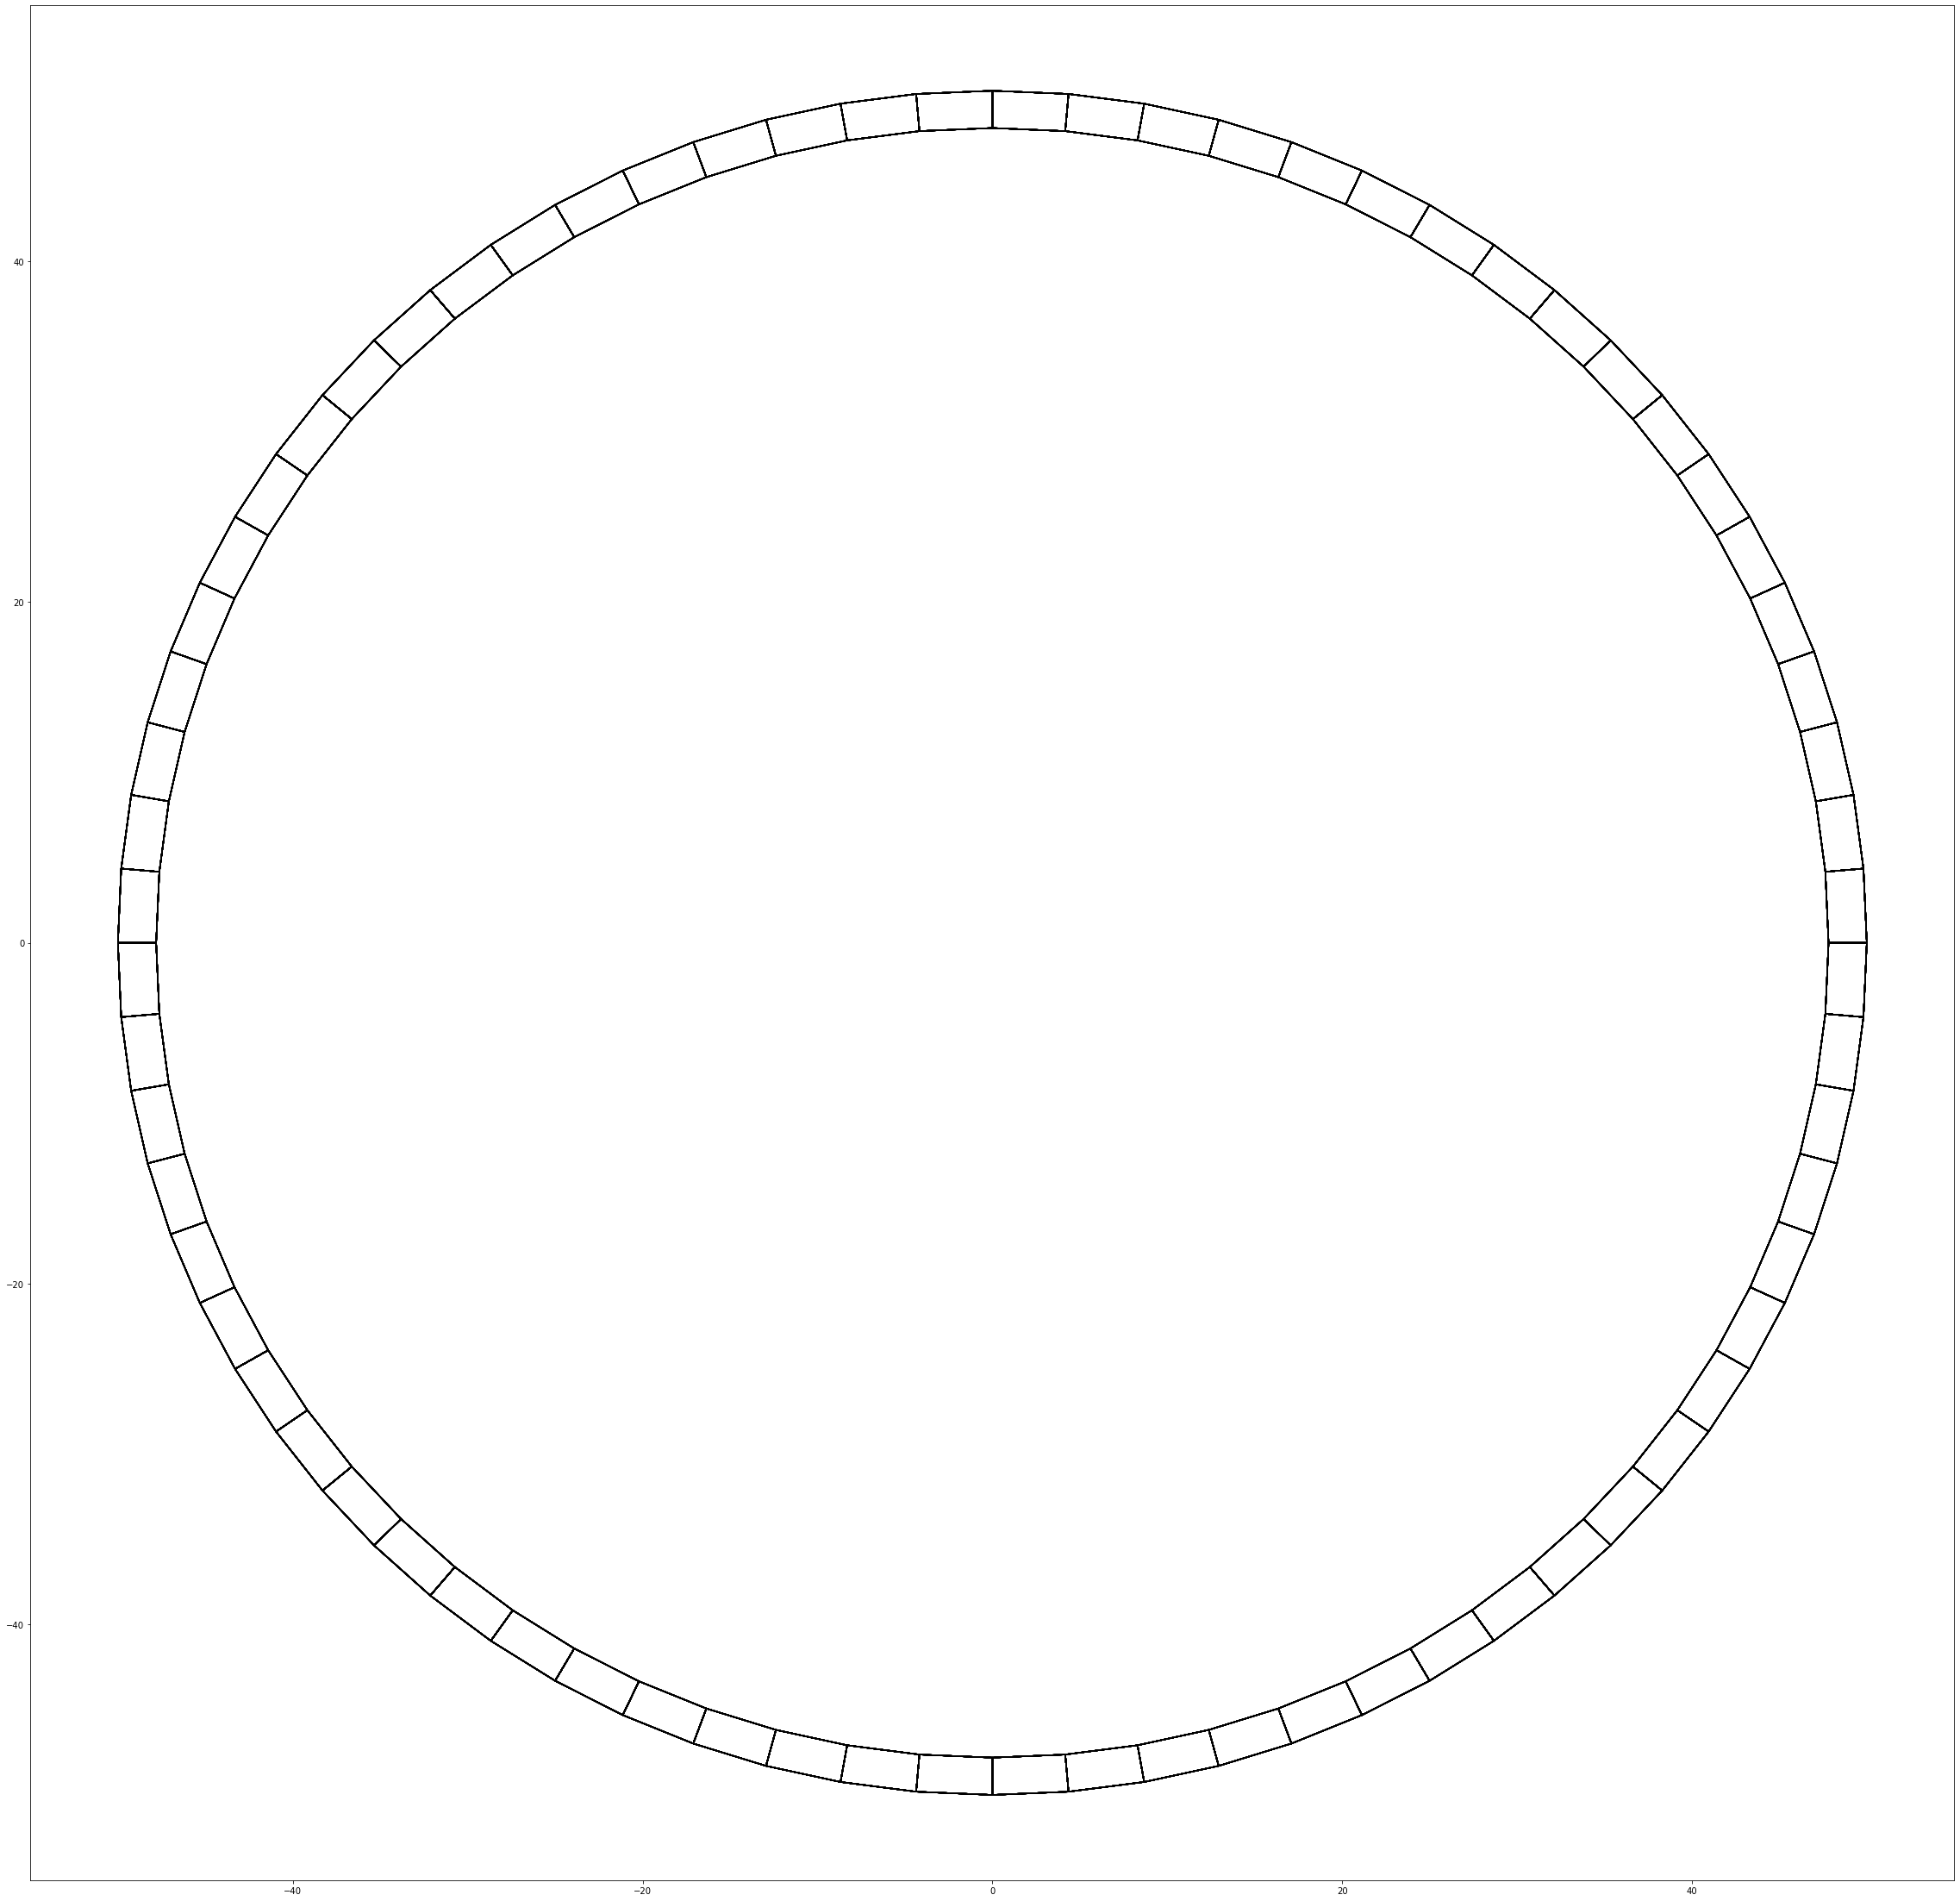

In [4]:
##
#%matplotlib

def polar1(x, y):
    """returns r, theta(degrees)
    """
    rads = (x ** 2 + y ** 2) ** .5
    theta_1 = math.degrees(math.atan2(y,x))
    theta_1 = (theta_1 + 360) % 360
    #print(theta_1)
    return round(rads,1), round(theta_1,2)

#List to note metal node numbers  
metal=[]


for i in range(len(ele)):
    counter=0
    counter1=0
    for j in range(4):
        radius,angle=(polar1(ele[i][j][0],ele[i][j][1]))
        if(round(radius,1)>=round(r[-2],1)
           and round(radius,1) <= round(r[-1],1) 
           and round((angle),1) >= round(math.degrees(theta[0]),1) 
           and round((angle),1) <= round(math.degrees(theta[-1]),1)):
            counter=counter+1
        if(counter==4):
            rx,ry=zip(*ele[i])
            metal.append(i)
            plt.plot(rx,ry,color='black')
                    
            
plt.show()

**The type of insert is mentioned # 1= Diamond, 2= Bezier diamond, 3= Ring, 4= square/rectangular insert** 

- **Diamond** - lx,by (points- (lx/2,0),(-l/2,0),(0,by/2),(0,-b/2)) 
- **Bezier diamond** - lx,by,r,theta (x,y)  (points- (points- (lx/2,0),(x,y),(0,by/2),(-x,y),(-l/2,0),(-x,-y),(0,-b/2),(x,-y)))
- **Ring** - r
- **Rectange** - lx,by (points- points- ((lx/2,by/2),(-lx/2,by/2),(-lx/2,-by/2),(lx/2,-by/2))

In [50]:
#Diamond 

metal=[]

Lx=2*IR+55
By=2*IR+55

#print((Lx/2, 0), (0,By/2), (-Lx/2,0), (0,-By/2))

metal_polygon=[(Lx/2, 0), (0,By/2), (-Lx/2,0), (0,-By/2)]

metal_polygon.append(metal_polygon[0])

polygon1 = Polygon(metal_polygon)
'''
for i in range(len(ele)):
    counter=0
    xs,ys=zip(*ele[i])
    plt.plot(xs,ys,color='yellow')
    #for j in range(4):
    if(polygon1.contains(Point(ele[i][0][0], ele[i][0][1]))):  #  ele[i][j][0]>=0 and ele[i][j][1]>=0):
        #counter=counter+1
        #if(counter==4):
        xs,ys=zip(*ele[i])
        plt.plot(xs,ys,color='black')
        metal.append(i)
'''
for i in range(len(ele)):
    p4_counter=0
    for j in range(4):
        if(polygon1.contains(Point(ele[i][j][0], ele[i][j][1]))): 
            p4_counter=p4_counter+1
            if(p4_counter==2):
                metal.append(i)        


    
#plt.show()

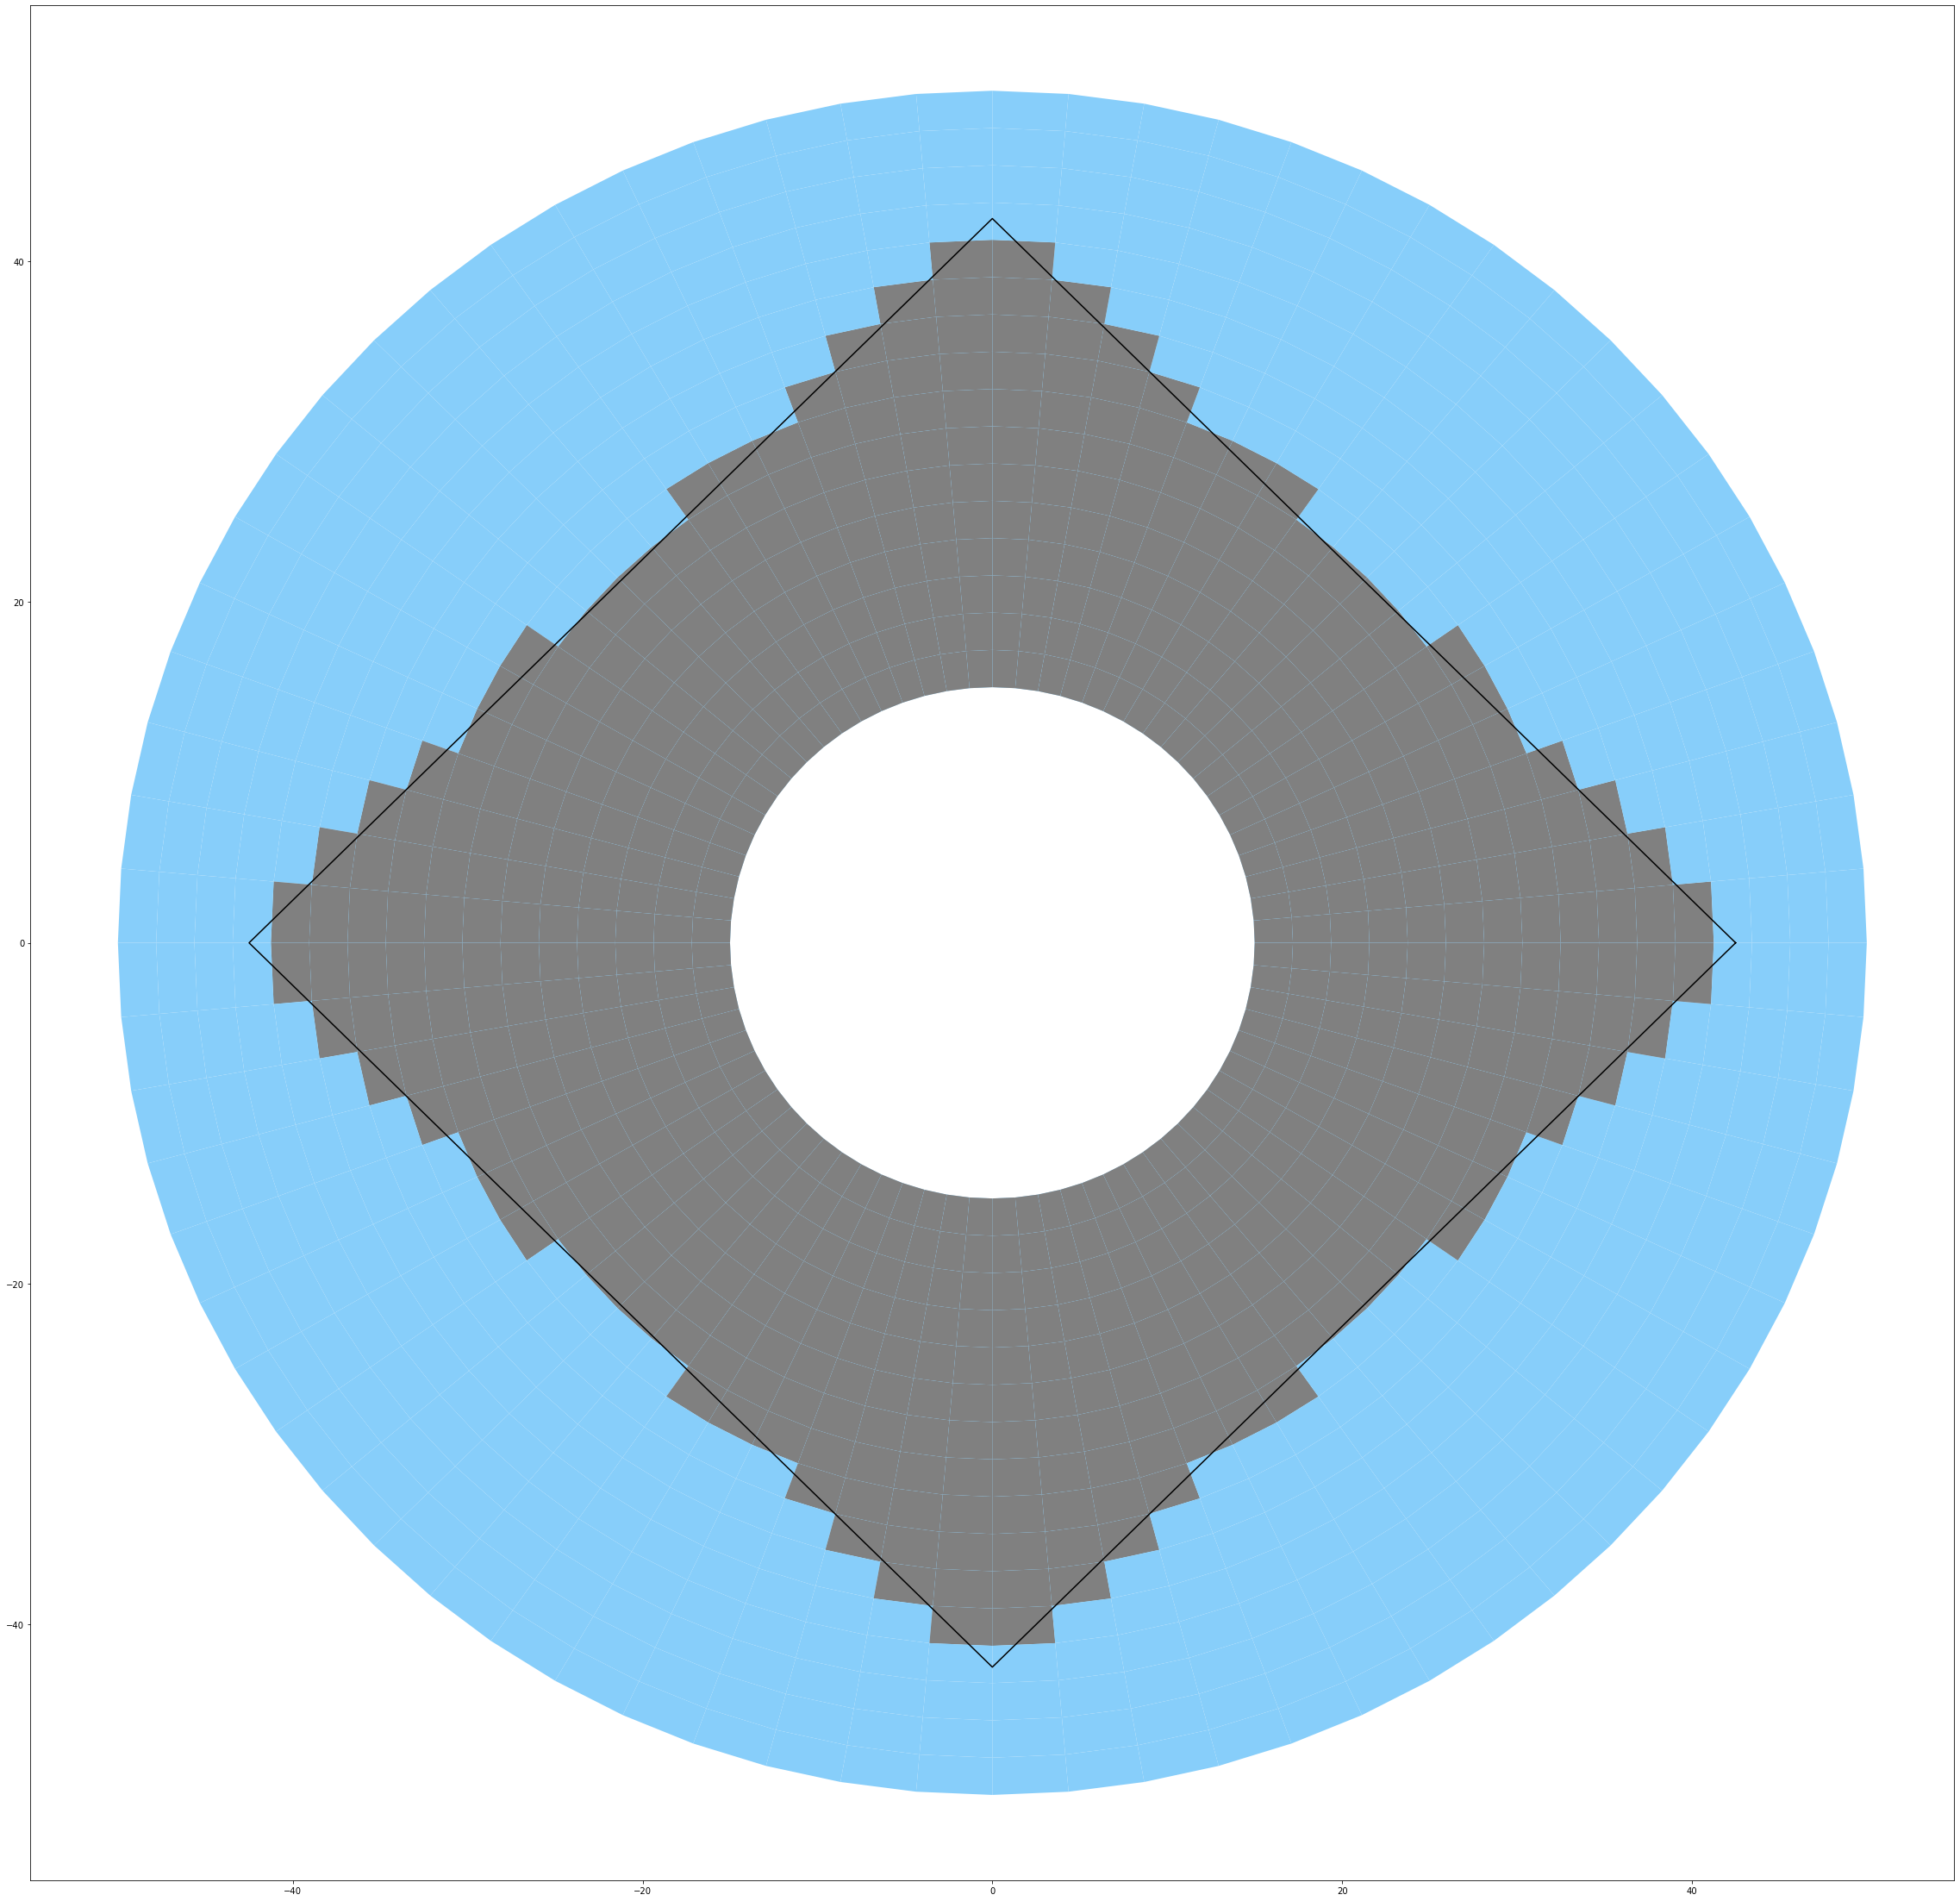

In [51]:
plt.plot([x[0] for x in metal_polygon],[x[1] for x in metal_polygon],color='black')


for i in range(((N-1)*thetasteps)):
    xs,ys=zip(*ele[i])
    #plt.plot(xs,ys,color='red')
    plt.fill(xs, ys, "lightskyblue")   
    #if(i in rubber):
    #    xs,ys=zip(*ele[i])
    #    plt.fill(xs, ys, "darksalmon")
    if(i in metal):
        xs,ys=zip(*ele[i])
        plt.fill(xs, ys, "gray")
        #plt.plot(xs,ys)

**Parameter defenitions**  8 parameters [IRp1,r1,θ1,ORp1,IRp2,r2,θ2,ORp2] 


- IRp1 = [0-16]
-IRp2 = [0-16]
-r1 =  [0-16]
-θ1 = [0-90]
-ORp1 = [0-16]
-ORp2 = [0-16]
-r2 =  [0-16]
-θ2 = [0-90]


POLYGON ((15.2 2.98, 46.1 14.19, 25.75 40.71, 8.14 13.06, 15.2 2.98))
[(15.2, 2.98), (46.1, 14.19), (25.75, 40.71), (8.14, 13.06), (15.2, 2.98)]


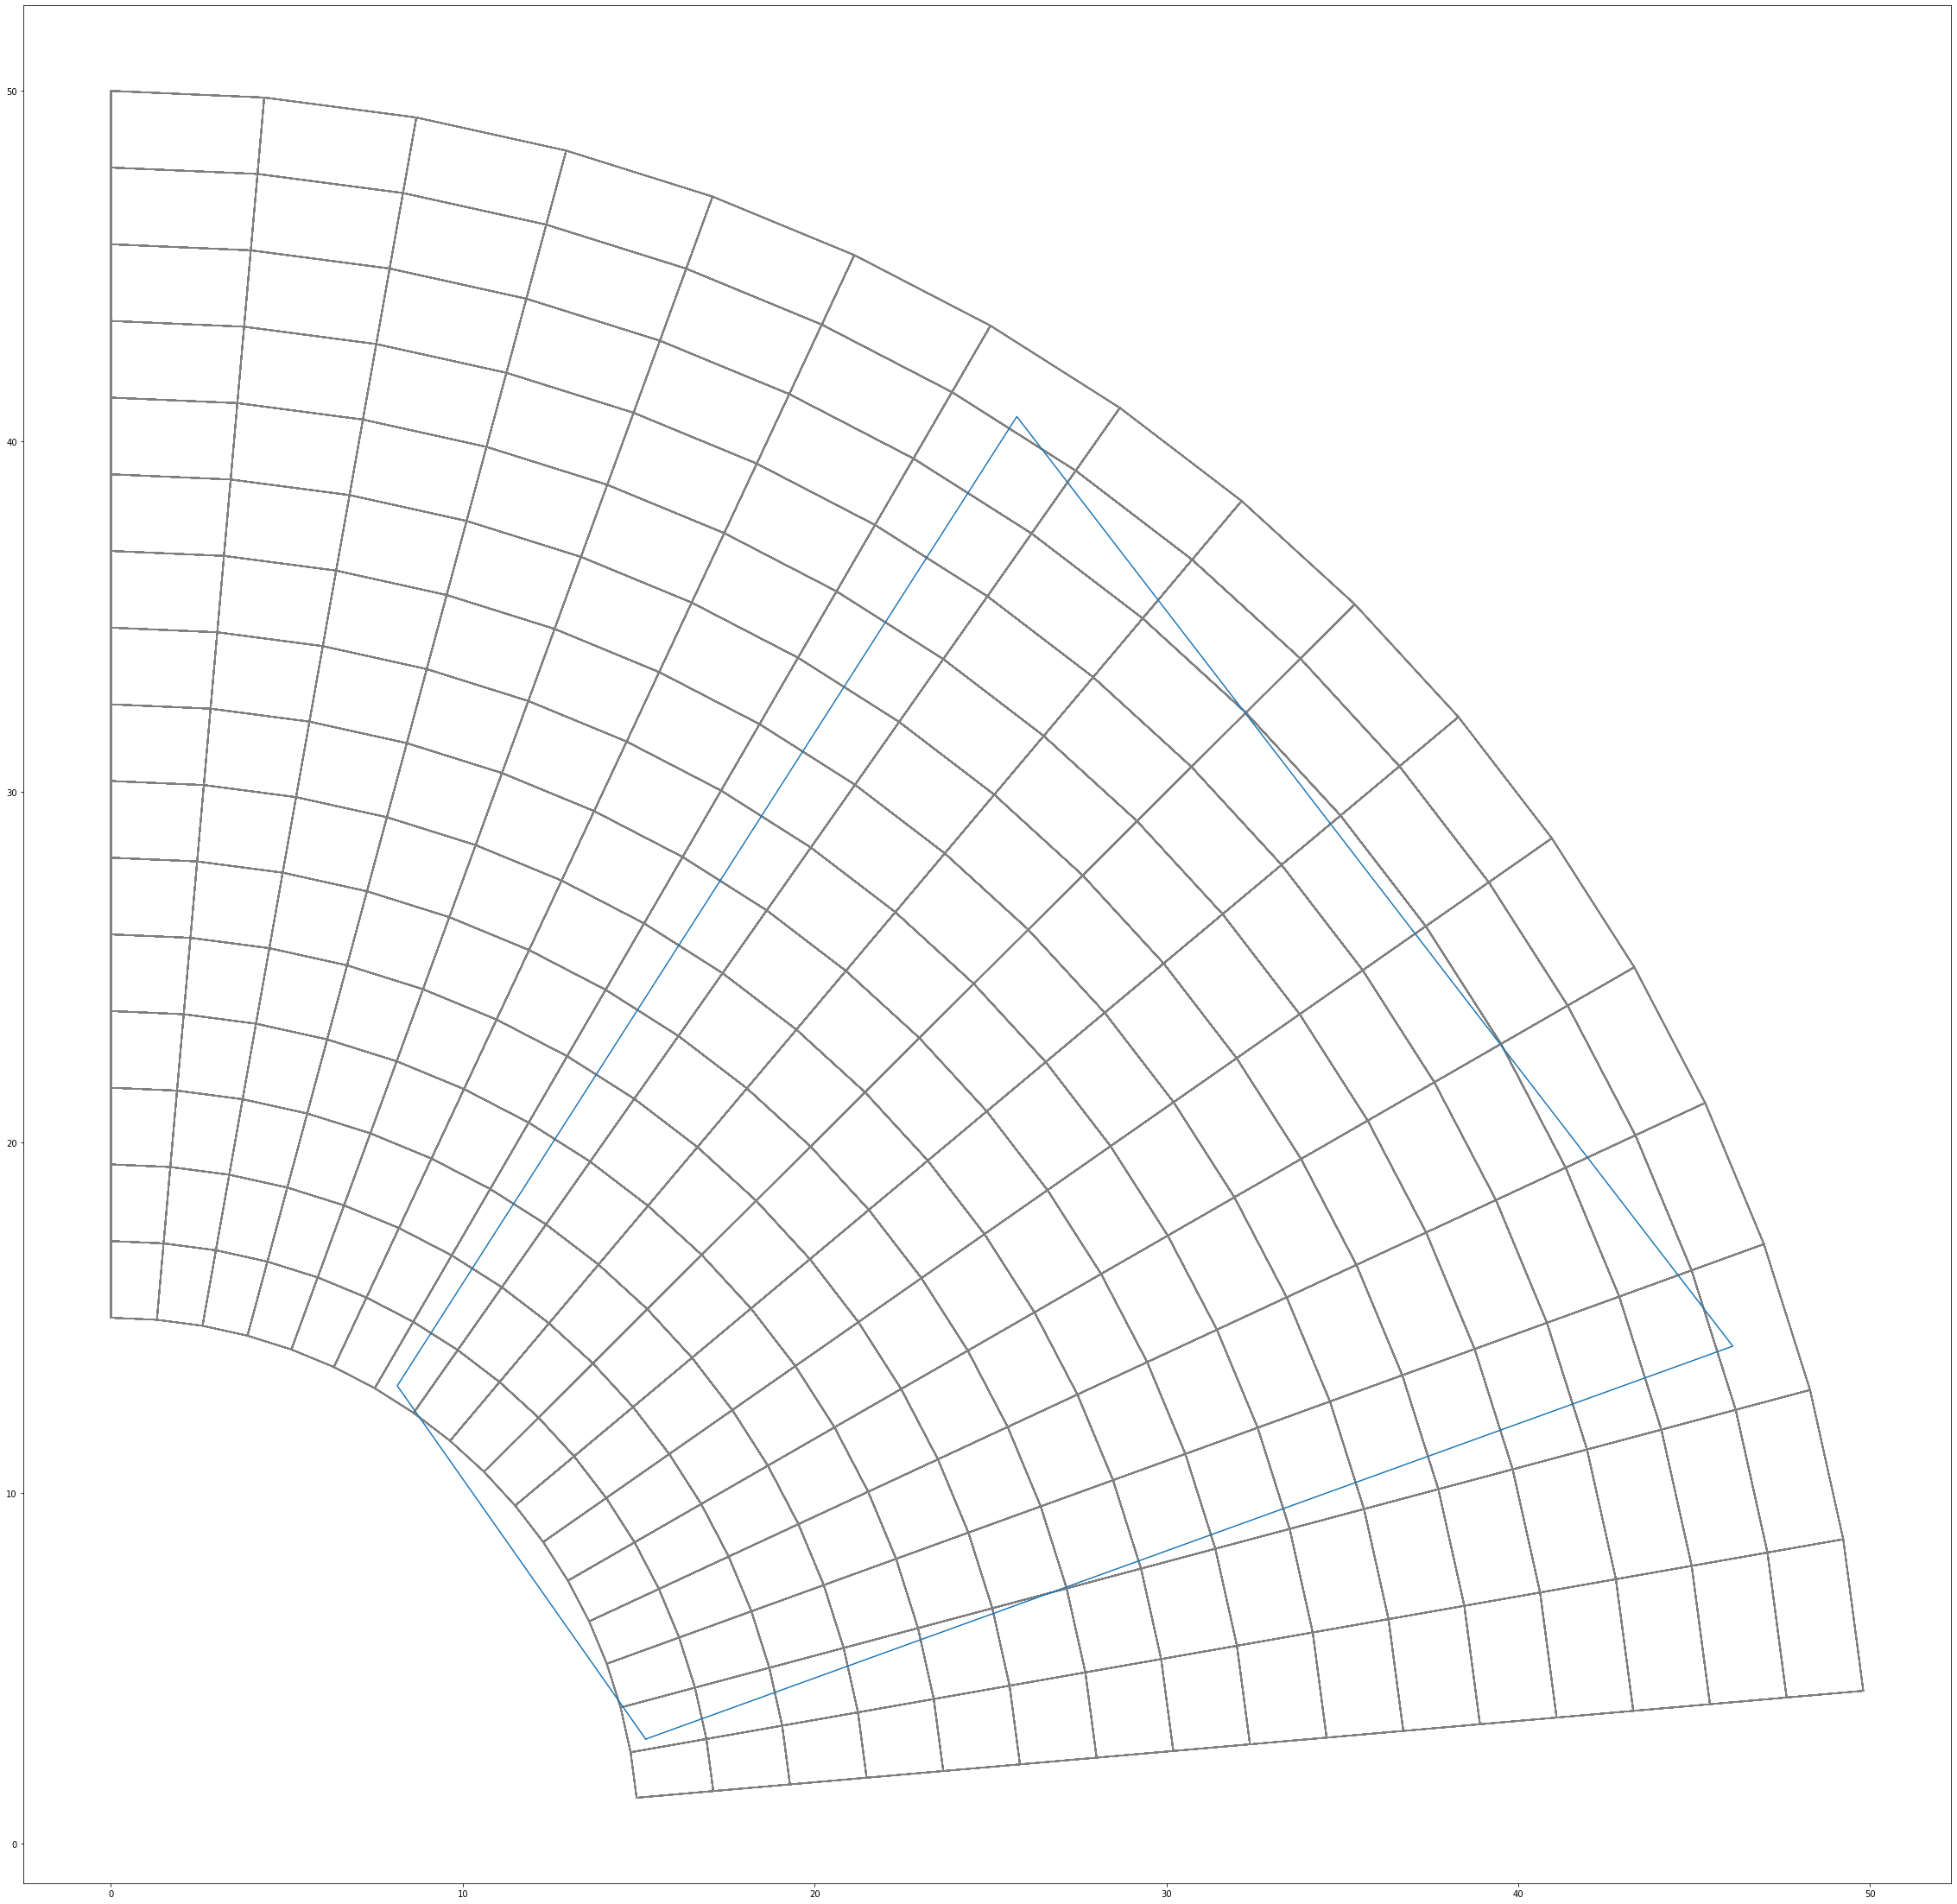

In [15]:
#%matplotlib

def pol2cart(rho, phi):
    x = rho * np.cos(math.radians(phi))
    y = rho * np.sin(math.radians(phi))
    return([x, y])





r1=r[2]
r2=r[14]
theta1=math.degrees(theta[0])
theta2=math.degrees(theta[10])


cordinate_list=[]

xs=[]
ys=[]
count=0

#visualizing just the first quadrant elements 
for i in range(len(ele)):
    counter=0
    for j in range(4):
        if(ele[i][j][0]>0 and ele[i][j][1]>0):
            #a.append(ele[i][j][0])
            #b.append(ele[i][j][1])
            counter=counter+1
            if(counter==4):
                xs,ys=zip(*ele[i])
                plt.plot(xs,ys,color='gray')
                x_avg=xs[0]+xs[1]+xs[2]+xs[3]
                y_avg=ys[0]+ys[1]+ys[2]+ys[3]
                if(count<(17*16)):
                    #plt.text((x_avg/4)-0.5,(y_avg/4)-0.5,str(count),fontsize=35)
                    cordinate_list.append(([(x_avg/4)-0.5,(y_avg/4)-0.5]))
                count=count+1


parameter=[1,0,0,2,10,0,0,10]

# for 1st being line 
polygon_list=[]
if(parameter[1]==0 and parameter[2]==0):
    polygon_list.append([cordinate_list[parameter[0]]])
    polygon_list.append([cordinate_list[parameter[3]+255]])

#for 1st being a curve
if(parameter[1]!=0 and parameter[2]!=0):
    polygon_list.append([cordinate_list[parameter[0]]])
    polygon_list.append([pol2cart(parameter[1],parameter[2])])
    polygon_list.append([cordinate_list[parameter[3]+255]])
    
    
#for 2nd being a line 
if(parameter[5]==0 and parameter[6]==0):
    polygon_list.append([cordinate_list[parameter[7]+255]])
    polygon_list.append([cordinate_list[parameter[4]]])
    

#for 2nd being a curve
if(parameter[5]!=0 and parameter[6]!=0):
    polygon_list.append([cordinate_list[parameter[7]+255]])
    polygon_list.append([pol2cart(parameter[5],parameter[6])])
    polygon_list.append([cordinate_list[parameter[4]]])

polygon_list.append(polygon_list[0])


#To make polygon_list compatible with 
polygons=[]
for x in polygon_list:
    polygons.append((round(x[0][0],2),round(x[0][1],2)))
polygon = Polygon(polygons)

    
#Visualizing the polygon formed 
plt.plot(*polygon.exterior.xy)
plt.show()



In [26]:
#%matplotlib
rubber=[]




for i in range(len(ele)):
    counter=0
    for j in range(4):
        if(ele[i][j][0]>0 and ele[i][j][1]>0):
            xs,ys=zip(*ele[i])
            plt.plot(xs,ys,color='green')
        if(i not in metal):
            if(polygon.contains(Point(ele[i][j][0], ele[i][j][1]))):  #  ele[i][j][0]>=0 and ele[i][j][1]>=0):
                counter=counter+1
                if(counter==4):
                    xs,ys=zip(*ele[i])
                    plt.plot(xs,ys,color='magenta')
                    rubber.append(i)


#plt.plot([x[0][0] for x in polygon_list],[x[0][1] for x in polygon_list],color='black')
#plt.plot([x[0] for x in metal_polygon],[x[1] for x in metal_polygon],color='black')
plt.plot(*polygon.exterior.xy)


plt.show()




In [28]:
#logic for squar, diamond and bezier diamond 
# to check % of overlapped area on insert 


#converted shapely polygon to sympy polygon to get intersected points 
spolygon1=sympy.Polygon(*mapping(polygon1)['coordinates'][0])  #metal
spolygon=sympy.Polygon(*mapping(polygon)['coordinates'][0])    #rubber_area





intersected_points=[]

intersected_points.append(((round(spolygon1.intersection(spolygon)[0][0],2),
                           (round(spolygon1.intersection(spolygon)[0][1],2)))))


intersected_points.append(((round(spolygon1.intersection(spolygon)[1][0],2),
                           (round(spolygon1.intersection(spolygon)[1][1],2)))))

#contains the intersected two points 
print(intersected_points)

#Visualizing the intersected area on the insert 

plt.scatter(spolygon1.intersection(spolygon)[0][0],(spolygon1.intersection(spolygon)[0][1]),s=250,c='red')
plt.scatter(spolygon1.intersection(spolygon)[1][0],(spolygon1.intersection(spolygon)[1][1]),s=250,c='red')
plt.plot([x[0][0] for x in polygon_list],[x[0][1] for x in polygon_list],color='black')
plt.plot([x[0] for x in metal_polygon],[x[1] for x in metal_polygon],color='black')
plt.show()



[(10.59, 16.91), (22.04, 5.46)]


The below logic will be modified 

In [9]:

rubber_lis=[]


                
for i in range(len(e_list)):
    if i in metal:
        continue
    for j in range(len(rubber)):
        
        ra,th=polar1(nodes[e_list[i][1]-1][1],nodes[e_list[i][1]-1][2])
        rub_r,rub_th=polar1(nodes[e_list[rubber[j]][1]-1][1],nodes[e_list[rubber[j]][1]-1][2])
        if((ra==rub_r) and (th== rub_th or th==180-(rub_th+360/thetasteps) or th==180+rub_th or th==360-(rub_th+360/thetasteps))):
       
            rubber_lis.append(i)
            
#print(rubber_lis,len(rubber_lis))






In [10]:
#removing replica entries in rubber_lis
lis=(np.unique(np.array(rubber_lis)))
print(len(lis),len(rubber_lis))

6120 122400


In [ ]:
for i in range(len(ele)):
    xs,ys=zip(*ele[i])
    plt.plot(xs,ys,color='blue')
    if(i in lis):
        xs,ys=zip(*ele[i])
        plt.plot(xs,ys,color='yellow')
    if(i in metal):
        xs,ys=zip(*ele[i])
        plt.plot(xs,ys,color='magenta')
    

    
#visualizing the final geometry in 2D
plt.plot([-40,40],[0,0],color='black')
plt.plot([0,0],[-40,40],color='black')
plt.show()

In [11]:
f = open("Test_insert.inp", "w")
f.write("**\n*HEADING\n**\n**\n**\n**\n*NODE\n")

#write nodes first with node number and x,y,z cordinates
for i in range(len(nodes)):
    f.write(str(nodes[i][0])+",\t"+str(nodes[i][1])+",\t"+str(nodes[i][2])+",\t"+str(nodes[i][3])+"\n")
    
#start specifying solid elements     
f.write("**\n** SOLID ELEMENTS\n**\n")
    
    
f.write("*ELEMENT, TYPE=C3D8H, ELSET=SOLID_RUBBER\n")
for i in range(len(lis)):
    f.write(str(e_list[lis[i]][0])+",\t"+
            str(e_list[lis[i]][1])+",\t"+
            str(e_list[lis[i]][2])+",\t"+
            str(e_list[lis[i]][3])+",\t"+
            str(e_list[lis[i]][4])+",\t"+
            str(e_list[lis[i]][5])+",\t"+
            str(e_list[lis[i]][6])+",\t"+
            str(e_list[lis[i]][7])+",\t"+
            str(e_list[lis[i]][8])+"\n")


f.write("*ELEMENT, TYPE=C3D8, ELSET=SOLID_METAL\n")
for i in range(len(metal)):
    f.write(str(e_list[metal[i]][0])+",\t"+
            str(e_list[metal[i]][1])+",\t"+
            str(e_list[metal[i]][2])+",\t"+
            str(e_list[metal[i]][3])+",\t"+
            str(e_list[metal[i]][4])+",\t"+
            str(e_list[metal[i]][5])+",\t"+
            str(e_list[metal[i]][6])+",\t"+
            str(e_list[metal[i]][7])+",\t"+
            str(e_list[metal[i]][8])+"\n")



'f.write("*ELEMENT, TYPE=C3D8, ELSET=SOLID_HIDE \n")\nfor i in range(len(hide)):\n    f.write(str(e_list[hide[i]][0])+",\t"+\n            str(e_list[hide[i]][1])+",\t"+\n            str(e_list[hide[i]][2])+",\t"+\n            str(e_list[hide[i]][3])+",\t"+\n            str(e_list[hide[i]][4])+",\t"+\n            str(e_list[hide[i]][5])+",\t"+\n            str(e_list[hide[i]][6])+",\t"+\n            str(e_list[hide[i]][7])+",\t"+\n            str(e_list[hide[i]][8])+"\n")\n'

The static part of the file which remains constant for all geometeries 

In [ ]:
f_1 = open("material_text.txt", "r")
f.write(f_1.read())
f.close()